# Plot average key rank against $p$-value

In [1]:
import math

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from os import path

from matplotlib.patheffects import withStroke
from matplotlib.pyplot import text, locator_params
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, AutoLocator, FixedLocator

from src.pollution.tools import file_suffix
from src.tools.plotter import store_sns, init_plots
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType

init_plots()

In [2]:
SCA_PALETTE = sns.light_palette(sns.color_palette()[2], n_colors=5)
DLLA_PALETTE = sns.light_palette(sns.color_palette()[0], n_colors=5)

In [3]:
methods = {
    "sca_hw": ("Profiled SCA ($\overline{kr}$)", SCA_PALETTE[3], "-"),
    "dlla9": ("DL-LA 9 class ($p$)", DLLA_PALETTE[3], "-"),
    "dlla2": ("Wegener DL-LA ($p$)", DLLA_PALETTE[2], "--"),
}

In [4]:
THRESHOLD_COLOR = "#FF000080"
Y_TICKS = 5

In [5]:
def fetch_results(db: Database, pollution: PollutionType, num_traces: str, dir_name = ""):
    suffix = ""
    if num_traces is not None:
        suffix = f"_{num_traces}"
    file_name = path.join(dir_name, f"results/{db.name}{suffix}.csv")

    df = pd.read_csv(file_name, sep=";")
    df = df[df.pollution == pollution.name].drop(columns=[df.pollution.name])

    gdf = df.groupby(df.method)

    return gdf, df

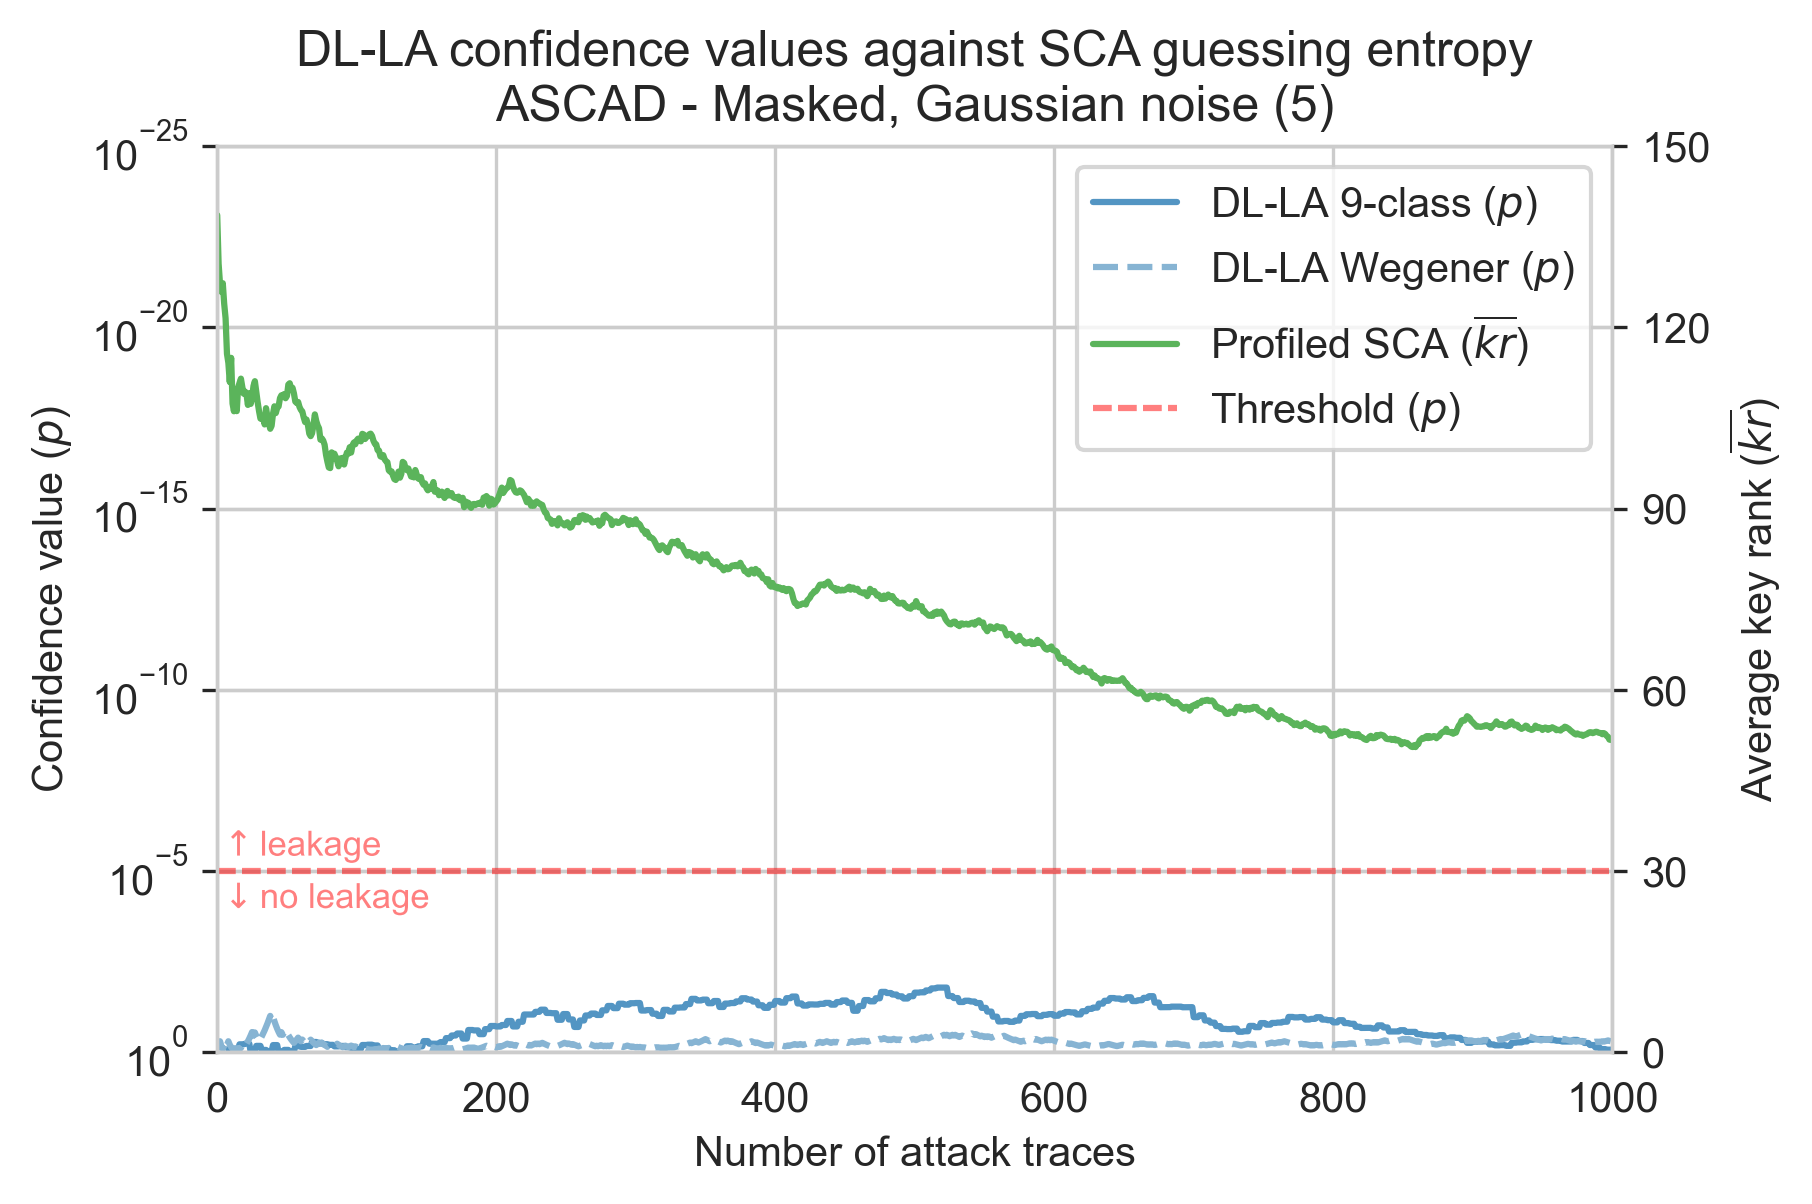

In [6]:
DB = Database.ascad
POLLUTION_TYPE = PollutionType.gauss
POLLUTION_PARAM = 5
POLL_TITLE = ""
if POLLUTION_TYPE:
    POLL_LOOKUP = {
        PollutionType.gauss: f", Gaussian noise ({POLLUTION_PARAM})"
    }
    POLL_TITLE = POLL_LOOKUP[POLLUTION_TYPE]

FILE_SUFFIX = file_suffix(POLLUTION_TYPE, POLLUTION_PARAM)
TITLE = f"DL-LA confidence values against SCA guessing entropy\nASCAD - Masked{POLL_TITLE}"

HIGH_PLOT = True

def plot_p_value():
    df = pd.read_csv(f"../la/dlla-p-gradient{FILE_SUFFIX}.csv")
    df = df.drop(columns=[df.columns[0]])
    df.columns = [f"{c} ($p$)" for c in df.columns]
    num_traces = max(df.index)

    g = sns.lineplot(data=df, palette=[DLLA_PALETTE[3], DLLA_PALETTE[2]])
    g.set(yscale="log",
          ylabel="Confidence value ($p$)",
          xlabel="Number of attack traces",
          title=TITLE,
          ylim=(10 ** 0, 10 ** -25), xlim=(0, num_traces + 1))
    g.yaxis.set_major_locator(FixedLocator(10. ** (-np.arange(0, 30, 5))))

    return g, num_traces

def plot_kr():
    df = pd.read_csv(f"results/sca-ge-{DB.name}{FILE_SUFFIX}.csv")
    df = df.drop(columns=[df.columns[0]])
    df.columns = [f"{c} ($\overline{{kr}}$)" for c in df.columns]
    num_traces = max(df.index)

    g = sns.lineplot(data=df, palette=[SCA_PALETTE[3]])
    if HIGH_PLOT:
        g.set(xlim=(0,num_traces + 1), ylim=(0,150), ylabel="Average key rank ($\overline{kr}$)")
        g.yaxis.set_major_locator(FixedLocator(np.arange(0, 151, 30)))
    else:
        g.set(xlim=(0,num_traces + 1), ylim=(0,50), ylabel="Average key rank ($\overline{kr}$)")
        g.yaxis.set_major_locator(FixedLocator(np.arange(0, 51, 10)))

    return g

def plot_threshold(g_p, g_kr, num_traces, p_thresh=10**-5):
    # Compute positioning
    max_kr = g_kr.get_ylim()[1]
    lin_max_p = abs(math.log(g_p.get_ylim()[1], 10))
    lin_p_thresh = abs(math.log(p_thresh, 10))
    line_loc = lin_p_thresh / lin_max_p * max_kr

    # Plot threshold
    t_line = [line_loc] * num_traces
    sns.lineplot(data={"Threshold ($p$)": t_line}, palette=[THRESHOLD_COLOR], dashes=[(3, 1)])

    # Threshold text positioning
    if HIGH_PLOT:
        up_margin = 2.5
        down_margin = -1.5
    else:
        up_margin = 1
        down_margin = -.5

    # Display threshold text
    t_up = text(0, line_loc + up_margin, '$\\uparrow$leakage', color=THRESHOLD_COLOR, size="small")
    t_down = text(0, line_loc + down_margin, '$\\downarrow$no leakage', va='top', color=THRESHOLD_COLOR, size="small")

    # Threshold text markup
    stroke = [withStroke(linewidth=2, foreground='w')]
    t_up.set_path_effects(stroke)
    t_down.set_path_effects(stroke)

KR_THRESH = 10


def plot():
    g, num_traces = plot_p_value()
    g.get_legend().remove()
    g2 = plt.twinx()
    plot_kr()

    plot_threshold(g, g2, num_traces)
    handles1, labels1 = g.get_legend_handles_labels()
    handles2, labels2 = g2.get_legend_handles_labels()
    g2.legend(handles1 + handles2, labels1 + labels2, loc="upper right")

    store_sns(g, f"sca-p-ascad-traces{FILE_SUFFIX}")


plot()